# Bounding Box Detection Testing with YOLO

This file was created and ran with Google Colab. Some issues may arise if attempted to run locally.

### Imports

In [ ]:
import os
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython import display

import torch
import ultralytics
from ultralytics import YOLO
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, auc
from scipy.interpolate import make_interp_spline
import shutil
from pathlib import Path
from PIL import Image

from google.colab import drive

HOME = os.getcwd()
display.clear_output()
ultralytics.checks()

Ultralytics YOLOv8.2.103 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 33.1/112.6 GB disk)


In [5]:
drive.mount('/content/drive')
annotations_folder = r"/content/drive/My Drive/cct20/cct20/annotations"
image_folder = r"/content/drive/My Drive/cct20/cct20/test_dataset"

Mounted at /content/drive


### Loading and Treating CCT20

In [ ]:
json_files = [f for f in os.listdir(annotations_folder) if f.endswith('.json')]
all_data = []
category_mapping = {}

for file in json_files:
    file_path = os.path.join(annotations_folder, file)
    with open(file_path, 'r') as f:
        data = json.load(f)

        for category in data['categories']:
            category_mapping[category['id']] = category['name']

        image_id_to_info = {}
        for img in data['images']:
            image_id_to_info[img['id']] = {
                'file_name': img['file_name'],
                'width': int(img['width'] / 2),
                'height': int(img['height'] / 2)
            }

        for ann in data['annotations']:
            if ann['image_id'] in image_id_to_info:
                image_info = image_id_to_info[ann['image_id']]
                # if ann['category_id'] != 30:
                all_data.append({
                    'annotation_id': ann['id'],
                    'image_id': image_info['file_name'],
                    'category_id': ann['category_id'],
                    'category_name': category_mapping[ann['category_id']],
                    'bbox': ann.get('bbox', None),
                    'image_width': image_info['width'],
                    'image_height': image_info['height']
                })

dataset_df = pd.DataFrame(all_data).set_index('annotation_id')

In [7]:
dataset_df = dataset_df.query('bbox.notna()')

In [ ]:
def scale_bbox(bbox):
    """Scales bounding box coordinates by a factor of 0.5 in both dimensions."""
    x_min, y_min, w, h = bbox

    # Scale coordinates to match downsized images
    x_min_scaled = int(x_min / 2)
    y_min_scaled = int(y_min / 2)
    w_scaled = int(w / 2)
    h_scaled = int(h / 2)

    return [x_min_scaled, y_min_scaled, w_scaled, h_scaled]

In [9]:
dataset_df['bbox']= dataset_df['bbox'].apply(scale_bbox)

In [ ]:
train_df, test_df = train_test_split(dataset_df, test_size=0.80, stratify=dataset_df['category_name'], random_state=31)
train_df, val_df = train_test_split(train_df, test_size=0.50, stratify=train_df['category_name'], random_state=37)

train_df.to_csv("train_annotations.csv", index=False)
val_df.to_csv("val_annotations.csv", index=False)
test_df.to_csv("test_annotations.csv", index=False)

In [ ]:
available_image_filenames = set(os.listdir(image_folder))
train_df = train_df[train_df['image_id'].isin(available_image_filenames)]
test_df = test_df[test_df['image_id'].isin(available_image_filenames)]
val_df = val_df[val_df['image_id'].isin(available_image_filenames)]

print("\nFiltered Train set size:", train_df.shape[0])
print("Filtered Validation set size:", val_df.shape[0])
print("Filtered Test set size:", test_df.shape[0])

print("\nChecking for duplicate image_ids:")
print(f"Duplicates in train_df: {train_df.duplicated(subset=['image_id']).sum()}")
print(f"Duplicates in val_df: {val_df.duplicated(subset=['image_id']).sum()}")
print(f"Duplicates in test_df: {test_df.duplicated(subset=['image_id']).sum()}")

missing_train = [img_id for img_id in train_df['image_id'].unique() if img_id not in available_image_filenames]
missing_val = [img_id for img_id in val_df['image_id'].unique() if img_id not in available_image_filenames]
missing_test = [img_id for img_id in test_df['image_id'].unique() if img_id not in available_image_filenames]

if missing_train or missing_val or missing_test:
    print("WARNING: Missing images after filtering:")
    if missing_train:
        print(f"  {len(missing_train)} image_ids in train_df are missing.")
    if missing_val:
        print(f"  {len(missing_val)} image_ids in val_df are missing.")
    if missing_test:
        print(f"  {len(missing_test)} image_ids in test_df are missing.")
    raise FileNotFoundError("Missing images after filtering. Check data and filtering logic.")


Filtered Train set size: 338
Filtered Validation set size: 345
Filtered Test set size: 2725

Checking for duplicate image_ids:
Duplicates in train_df: 2
Duplicates in val_df: 0
Duplicates in test_df: 114


### Preparing Dataset for YOLO

In [ ]:
def create_yolo_labels(df, output_dir, image_dir, category_mapping):
    os.makedirs(output_dir, exist_ok=True)

    name_to_id = {name: i for i, name in enumerate(sorted(category_mapping.values()))}
    print("YOLO Class Mapping:", name_to_id)

    for image_filename, group in df.groupby('image_id'):
        image_path = os.path.join(image_dir, image_filename)
        try:
            with Image.open(image_path) as img:
                img_width, img_height = img.size
        except (FileNotFoundError, OSError) as e:
            print(f"Error processing image {image_path}: {e}")
            continue

        label_filepath = os.path.join(output_dir, f"{os.path.splitext(image_filename)[0]}.txt")
        with open(label_filepath, 'w') as f:
            for _, row in group.iterrows():
                yolo_class_id = name_to_id[row['category_name']]

                x_min, y_min, w, h = row['bbox']
                x_center = (x_min + w / 2) / img_width
                y_center = (y_min + h / 2) / img_height
                width = w / img_width
                height = h / img_height
                f.write(f"{yolo_class_id} {x_center} {y_center} {width} {height}\n")

In [ ]:
dataset_root = "/content/datasets/my_custom_dataset"
os.makedirs(dataset_root, exist_ok=True)

train_dir = os.path.join(dataset_root, "train")
val_dir= os.path.join(dataset_root, "val")
test_dir = os.path.join(dataset_root, "test")
train_label_dir = os.path.join(train_dir, "labels")
val_label_dir = os.path.join(val_dir, "labels")
test_label_dir = os.path.join(test_dir, "labels")
train_image_dir = os.path.join(train_dir, "images")
val_image_dir = os.path.join(val_dir, "images")
test_image_dir = os.path.join(test_dir, "images")

In [14]:
os.makedirs(train_label_dir, exist_ok=True)
os.makedirs(val_label_dir, exist_ok=True)
os.makedirs(test_label_dir, exist_ok=True)
os.makedirs(train_image_dir, exist_ok=True)
os.makedirs(val_image_dir, exist_ok=True)
os.makedirs(test_image_dir, exist_ok=True)

In [ ]:
# Create Yolo Variables
create_yolo_labels(train_df, train_label_dir, image_folder, category_mapping)
create_yolo_labels(val_df, val_label_dir, image_folder, category_mapping)
create_yolo_labels(test_df, test_label_dir, image_folder, category_mapping)

YOLO Class Mapping: {'badger': 0, 'bird': 1, 'bobcat': 2, 'car': 3, 'cat': 4, 'coyote': 5, 'deer': 6, 'dog': 7, 'empty': 8, 'fox': 9, 'opossum': 10, 'rabbit': 11, 'raccoon': 12, 'rodent': 13, 'skunk': 14, 'squirrel': 15}
YOLO Class Mapping: {'badger': 0, 'bird': 1, 'bobcat': 2, 'car': 3, 'cat': 4, 'coyote': 5, 'deer': 6, 'dog': 7, 'empty': 8, 'fox': 9, 'opossum': 10, 'rabbit': 11, 'raccoon': 12, 'rodent': 13, 'skunk': 14, 'squirrel': 15}
YOLO Class Mapping: {'badger': 0, 'bird': 1, 'bobcat': 2, 'car': 3, 'cat': 4, 'coyote': 5, 'deer': 6, 'dog': 7, 'empty': 8, 'fox': 9, 'opossum': 10, 'rabbit': 11, 'raccoon': 12, 'rodent': 13, 'skunk': 14, 'squirrel': 15}


In [ ]:
# Move images
train_count = 0
val_count = 0
test_count = 0
for filename in train_df['image_id'].unique():
    src_path = os.path.join(image_folder, filename)
    dst_path = os.path.join(train_image_dir, filename)
    try:
        shutil.copy(src_path, dst_path)
        train_count += 1
    except (FileNotFoundError, Exception) as e:
        print(f"Error copying image {filename}: {e}")

for filename in val_df['image_id'].unique():
    src_path = os.path.join(image_folder, filename)
    dst_path = os.path.join(val_image_dir, filename)
    try:
        shutil.copy(src_path, dst_path)
        val_count += 1
    except (FileNotFoundError, Exception) as e:
        print(f"Error copying image {filename}: {e}")

for filename in test_df['image_id'].unique():
    src_path = os.path.join(image_folder, filename)
    dst_path = os.path.join(test_image_dir, filename)
    try:
        shutil.copy(src_path, dst_path)
        test_count += 1
    except (FileNotFoundError, Exception) as e:
        print(f"Error copying image {filename}: {e}")


In [17]:
print("\nImage Copying Verification:")
print(f"Successfully copied {train_count} images to the training set.")
print(f"Successfully copied {val_count} images to the validation set.")
print(f"Successfully copied {test_count} images to the test set.")
total_copied = train_count + val_count + test_count
print(f"Total images copied: {total_copied}")


Image Copying Verification:
Successfully copied 336 images to the training set.
Successfully copied 345 images to the validation set.
Successfully copied 2611 images to the test set.
Total images copied: 3292


In [18]:
class_names = [name for _, name in sorted(category_mapping.items())]
data_yaml_content = f"""
train: {train_image_dir}
val: {val_image_dir}
test: {test_image_dir}
nc: {len(class_names)}
names: {class_names}
"""
with open("data.yaml", 'w') as f:
    f.write(data_yaml_content)

### Model Import

In [19]:
model = YOLO(r"/content/drive/My Drive/cct20/cct20/my_yolo_project/train22/weights/best.pt")  # Use the correct path to best.pt
results = model.val(split="test")
print(results)

Ultralytics YOLOv8.2.103 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 218 layers, 25,849,024 parameters, 0 gradients, 78.7 GFLOPs


100%|██████████| 755k/755k [00:00<00:00, 28.0MB/s]
val: Scanning /content/datasets/my_custom_dataset/test/labels... 2611 images, 0 backgrounds, 39 corrupt: 100%|██████████| 2611/2611 [00:01<00:00, 2022.96it/s]

val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5858bfcd-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [       1.25        1.25]
val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5858c28b-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [       1.25        1.25]
val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5860ef5d-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1159]
val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5874d3b4-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0885]
val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5874d409-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [       1.25        

val: New cache created: /content/datasets/my_custom_dataset/test/labels.cache


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 161/161 [01:55<00:00,  1.40it/s]


                   all       2572       2683       0.91      0.759      0.799       0.55
               opossum          2          2          1          0     0.0934     0.0798
               raccoon         59         83      0.746      0.651      0.686      0.422
              squirrel        246        255      0.924      0.902      0.941      0.696
                bobcat        130        130      0.969          1      0.991      0.892
                 skunk        220        225      0.874      0.898      0.922      0.617
                   dog        238        255       0.84      0.906       0.93      0.691
                coyote          8          8          1      0.798      0.982      0.706
                rabbit        135        153      0.855      0.902      0.921      0.651
                   cat          1          1          1          0          0          0
                badger        641        645      0.953      0.963      0.978      0.574
                 empt

### Testing

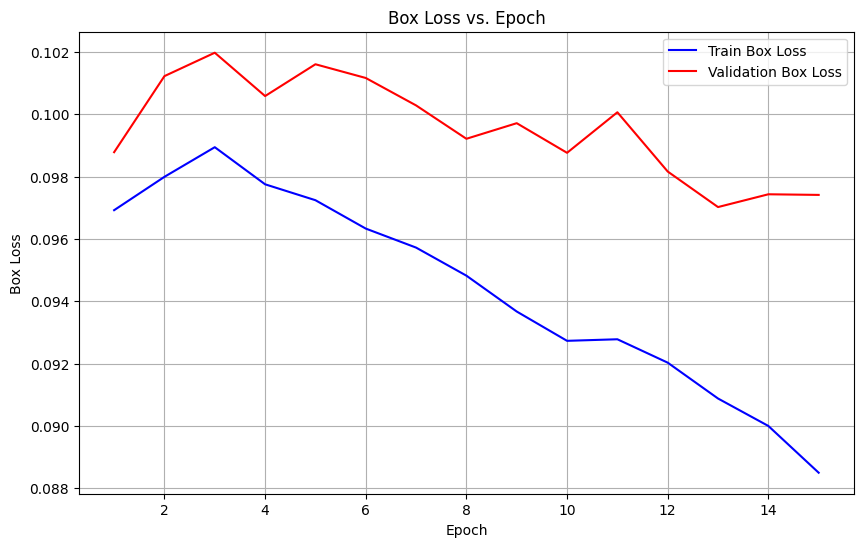

In [ ]:
training_run_dir = r"/content/drive/My Drive/cct20/cct20/my_yolo_project/train22"

results_csv_path = os.path.join(training_run_dir, "results.csv")

if not os.path.exists(results_csv_path):
    raise FileNotFoundError(f"results.csv file not found at: {results_csv_path}. "
                            f"Make sure you provided the correct training run directory.")

try:
    results_df = pd.read_csv(results_csv_path)
except Exception as e:
    raise FileNotFoundError(f"Error reading results.csv: {e}. Check for file corruption.")

# Remove column spaces
results_df.columns = results_df.columns.str.strip()

plt.figure(figsize=(10, 6))

plt.plot(results_df['epoch'], results_df['train/box_loss'], label='Train Box Loss', color='blue')

if 'val/box_loss' in results_df.columns:
    plt.plot(results_df['epoch'], results_df['val/box_loss'], label='Validation Box Loss', color='red')

plt.xlabel('Epoch')
plt.ylabel('Box Loss')
plt.title('Box Loss vs. Epoch')
plt.legend()
plt.grid(True)
plt.show()

Ultralytics YOLOv8.2.103 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 218 layers, 25,849,024 parameters, 0 gradients, 78.7 GFLOPs


val: Scanning /content/datasets/my_custom_dataset/test/labels.cache... 2611 images, 0 backgrounds, 39 corrupt: 100%|██████████| 2611/2611 [00:00<?, ?it/s]

val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5858bfcd-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [       1.25        1.25]
val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5858c28b-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [       1.25        1.25]
val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5860ef5d-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1159]
val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5874d3b4-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0885]
val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5874d409-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [       1.25        


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|▉         | 16/161 [00:42<05:51,  2.42s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 161/161 [06:48<00:00,  2.54s/it]


                   all       2572       2683      0.922      0.756      0.796      0.536
               opossum          2          2          1          0      0.094     0.0799
               raccoon         59         83      0.764      0.651      0.672      0.399
              squirrel        246        255      0.924      0.905      0.941      0.686
                bobcat        130        130      0.969          1      0.991      0.892
                 skunk        220        225      0.881      0.891      0.913      0.601
                   dog        238        255      0.858        0.9      0.917      0.672
                coyote          8          8          1      0.803      0.982      0.705
                rabbit        135        153      0.861      0.902       0.92       0.64
                   cat          1          1          1          0          0          0
                badger        641        645      0.965       0.96      0.972      0.548
                 empt

val: Scanning /content/datasets/my_custom_dataset/test/labels.cache... 2611 images, 0 backgrounds, 39 corrupt: 100%|██████████| 2611/2611 [00:00<?, ?it/s]

val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5858bfcd-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [       1.25        1.25]
val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5858c28b-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [       1.25        1.25]
val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5860ef5d-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1159]
val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5874d3b4-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0885]
val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5874d409-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [       1.25        


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 161/161 [02:02<00:00,  1.31it/s]


                   all       2572       2683      0.855      0.757      0.808      0.574
               opossum          2          2          1          0      0.107     0.0964
               raccoon         59         83      0.764      0.651       0.72      0.456
              squirrel        246        255      0.924      0.905      0.941      0.721
                bobcat        130        130      0.969          1      0.991      0.892
                 skunk        220        225      0.882        0.9      0.924      0.646
                   dog        238        255      0.858        0.9      0.933      0.716
                coyote          8          8          1      0.803      0.982      0.721
                rabbit        135        153      0.861      0.902      0.924      0.678
                   cat          1          1          0          0          0          0
                badger        641        645      0.965      0.963      0.979        0.6
                 empt

val: Scanning /content/datasets/my_custom_dataset/test/labels.cache... 2611 images, 0 backgrounds, 39 corrupt: 100%|██████████| 2611/2611 [00:00<?, ?it/s]

val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5858bfcd-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [       1.25        1.25]
val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5858c28b-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [       1.25        1.25]
val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5860ef5d-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1159]
val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5874d3b4-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0885]
val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5874d409-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [       1.25        


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 161/161 [02:02<00:00,  1.31it/s]


                   all       2572       2683      0.855      0.757      0.797      0.569
               opossum          2          2          1          0          0          0
               raccoon         59         83      0.764      0.651      0.715      0.461
              squirrel        246        255      0.924      0.905      0.939      0.723
                bobcat        130        130       0.97          1      0.991      0.892
                 skunk        220        225      0.882        0.9      0.925      0.648
                   dog        238        255      0.858        0.9      0.931      0.717
                coyote          8          8          1      0.803      0.982      0.731
                rabbit        135        153      0.861      0.902      0.914      0.675
                   cat          1          1          0          0          0          0
                badger        641        645      0.965      0.963      0.979        0.6
                 empt

val: Scanning /content/datasets/my_custom_dataset/test/labels.cache... 2611 images, 0 backgrounds, 39 corrupt: 100%|██████████| 2611/2611 [00:00<?, ?it/s]

val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5858bfcd-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [       1.25        1.25]
val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5858c28b-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [       1.25        1.25]
val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5860ef5d-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1159]
val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5874d3b4-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0885]
val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5874d409-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [       1.25        


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 161/161 [02:02<00:00,  1.32it/s]


                   all       2572       2683      0.855      0.758      0.792      0.567
               opossum          2          2          1          0          0          0
               raccoon         59         83      0.763      0.651      0.709      0.466
              squirrel        246        255      0.923      0.906      0.935      0.722
                bobcat        130        130       0.97          1      0.991      0.892
                 skunk        220        225      0.882      0.902      0.924      0.649
                   dog        238        255      0.859      0.905      0.931       0.72
                coyote          8          8          1      0.805       0.93        0.7
                rabbit        135        153      0.859      0.902      0.911      0.679
                   cat          1          1          0          0          0          0
                badger        641        645      0.964      0.963      0.977        0.6
                 empt

val: Scanning /content/datasets/my_custom_dataset/test/labels.cache... 2611 images, 0 backgrounds, 39 corrupt: 100%|██████████| 2611/2611 [00:00<?, ?it/s]

val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5858bfcd-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [       1.25        1.25]
val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5858c28b-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [       1.25        1.25]
val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5860ef5d-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1159]
val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5874d3b4-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0885]
val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5874d409-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [       1.25        


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  12%|█▏        | 19/161 [00:15<01:49,  1.30it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a498b999bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a498b999bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", 

                   all       2572       2683      0.792      0.751      0.787      0.566
               opossum          2          2          0          0          0          0
               raccoon         59         83      0.771      0.647      0.706      0.472
              squirrel        246        255      0.924      0.901      0.932      0.721
                bobcat        130        130       0.97          1      0.991      0.892
                 skunk        220        225      0.896      0.898      0.925       0.65
                   dog        238        255       0.86      0.894      0.923      0.718
                coyote          8          8          1       0.75      0.875      0.678
                rabbit        135        153      0.867      0.902      0.911      0.682
                   cat          1          1          0          0          0          0
                badger        641        645      0.967      0.963      0.977        0.6
                 empt

val: Scanning /content/datasets/my_custom_dataset/test/labels.cache... 2611 images, 0 backgrounds, 39 corrupt: 100%|██████████| 2611/2611 [00:00<?, ?it/s]

val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5858bfcd-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [       1.25        1.25]
val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5858c28b-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [       1.25        1.25]
val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5860ef5d-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1159]
val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5874d3b4-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0885]
val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5874d409-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [       1.25        


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 161/161 [02:03<00:00,  1.30it/s]


                   all       2572       2683       0.79      0.754      0.786      0.567
               opossum          2          2          0          0          0          0
               raccoon         59         83      0.771      0.651      0.709      0.481
              squirrel        246        255      0.924      0.906      0.929      0.721
                bobcat        130        130       0.97          1      0.991      0.892
                 skunk        220        225      0.883      0.902      0.922       0.65
                   dog        238        255      0.858      0.902      0.919      0.717
                coyote          8          8          1       0.75      0.875      0.678
                rabbit        135        153      0.863      0.902      0.912      0.683
                   cat          1          1          0          0          0          0
                badger        641        645      0.966      0.963      0.977        0.6
                 empt

val: Scanning /content/datasets/my_custom_dataset/test/labels.cache... 2611 images, 0 backgrounds, 39 corrupt: 100%|██████████| 2611/2611 [00:00<?, ?it/s]

val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5858bfcd-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [       1.25        1.25]
val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5858c28b-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [       1.25        1.25]
val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5860ef5d-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1159]
val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5874d3b4-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0885]
val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5874d409-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [       1.25        


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 161/161 [02:02<00:00,  1.31it/s]


                   all       2572       2683      0.796      0.743      0.782      0.565
               opossum          2          2          0          0          0          0
               raccoon         59         83      0.788      0.627      0.703      0.478
              squirrel        246        255      0.923      0.898      0.925      0.717
                bobcat        130        130      0.977          1      0.991      0.892
                 skunk        220        225       0.91      0.893       0.92      0.649
                   dog        238        255      0.862      0.882      0.911      0.712
                coyote          8          8          1       0.75      0.875      0.678
                rabbit        135        153      0.878      0.895       0.91      0.682
                   cat          1          1          0          0          0          0
                badger        641        645      0.969      0.958      0.974      0.599
                 empt

val: Scanning /content/datasets/my_custom_dataset/test/labels.cache... 2611 images, 0 backgrounds, 39 corrupt: 100%|██████████| 2611/2611 [00:00<?, ?it/s]

val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5858bfcd-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [       1.25        1.25]
val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5858c28b-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [       1.25        1.25]
val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5860ef5d-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1159]
val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5874d3b4-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0885]
val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5874d409-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [       1.25        


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 161/161 [02:02<00:00,  1.31it/s]


                   all       2572       2683      0.807       0.73      0.776      0.563
               opossum          2          2          0          0          0          0
               raccoon         59         83        0.8      0.627      0.705       0.48
              squirrel        246        255      0.923      0.894      0.923      0.716
                bobcat        130        130      0.992          1      0.991      0.892
                 skunk        220        225      0.909      0.889      0.918      0.648
                   dog        238        255      0.871      0.875      0.908      0.711
                coyote          8          8          1      0.625      0.812      0.639
                rabbit        135        153      0.889      0.889      0.907      0.683
                   cat          1          1          0          0          0          0
                badger        641        645      0.969      0.957      0.974      0.599
                 empt

val: Scanning /content/datasets/my_custom_dataset/test/labels.cache... 2611 images, 0 backgrounds, 39 corrupt: 100%|██████████| 2611/2611 [00:00<?, ?it/s]

val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5858bfcd-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [       1.25        1.25]
val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5858c28b-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [       1.25        1.25]
val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5860ef5d-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1159]
val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5874d3b4-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0885]
val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5874d409-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [       1.25        


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 161/161 [02:02<00:00,  1.32it/s]


                   all       2572       2683      0.811      0.706      0.765      0.557
               opossum          2          2          0          0          0          0
               raccoon         59         83      0.806      0.602      0.697      0.474
              squirrel        246        255      0.929      0.878      0.916      0.713
                bobcat        130        130      0.992          1      0.991      0.892
                 skunk        220        225      0.917      0.889      0.918      0.648
                   dog        238        255      0.888      0.867      0.906       0.71
                coyote          8          8          1        0.5       0.75      0.588
                rabbit        135        153      0.893      0.876      0.902       0.68
                   cat          1          1          0          0          0          0
                badger        641        645      0.972      0.953      0.972      0.599
                 empt

val: Scanning /content/datasets/my_custom_dataset/test/labels.cache... 2611 images, 0 backgrounds, 39 corrupt: 100%|██████████| 2611/2611 [00:00<?, ?it/s]

val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5858bfcd-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [       1.25        1.25]
val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5858c28b-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [       1.25        1.25]
val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5860ef5d-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1159]
val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5874d3b4-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0885]
val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5874d409-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [       1.25        


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 161/161 [02:02<00:00,  1.31it/s]


                   all       2572       2683      0.814      0.694       0.76      0.555
               opossum          2          2          0          0          0          0
               raccoon         59         83       0.81      0.566      0.683      0.466
              squirrel        246        255      0.929      0.875      0.914      0.712
                bobcat        130        130      0.992          1      0.991      0.892
                 skunk        220        225      0.921      0.884      0.916      0.647
                   dog        238        255      0.898      0.859      0.903      0.709
                coyote          8          8          1        0.5       0.75      0.588
                rabbit        135        153      0.899      0.869      0.899      0.678
                   cat          1          1          0          0          0          0
                badger        641        645      0.973      0.947      0.969      0.597
                 empt

val: Scanning /content/datasets/my_custom_dataset/test/labels.cache... 2611 images, 0 backgrounds, 39 corrupt: 100%|██████████| 2611/2611 [00:00<?, ?it/s]

val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5858bfcd-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [       1.25        1.25]
val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5858c28b-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [       1.25        1.25]
val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5860ef5d-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1159]
val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5874d3b4-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0885]
val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5874d409-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [       1.25        


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 161/161 [02:02<00:00,  1.31it/s]


                   all       2572       2683       0.82      0.681      0.754      0.553
               opossum          2          2          0          0          0          0
               raccoon         59         83       0.83       0.53      0.673      0.462
              squirrel        246        255      0.933      0.871      0.913      0.711
                bobcat        130        130      0.992      0.992      0.991      0.892
                 skunk        220        225      0.932      0.853      0.903      0.641
                   dog        238        255      0.916      0.855      0.902      0.709
                coyote          8          8          1        0.5       0.75      0.588
                rabbit        135        153      0.903      0.856      0.894      0.675
                   cat          1          1          0          0          0          0
                badger        641        645      0.978      0.944      0.968      0.597
                 empt

val: Scanning /content/datasets/my_custom_dataset/test/labels.cache... 2611 images, 0 backgrounds, 39 corrupt: 100%|██████████| 2611/2611 [00:00<?, ?it/s]

val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5858bfcd-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [       1.25        1.25]
val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5858c28b-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [       1.25        1.25]
val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5860ef5d-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1159]
val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5874d3b4-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0885]
val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5874d409-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [       1.25        


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 161/161 [02:02<00:00,  1.32it/s]


                   all       2572       2683      0.824      0.662      0.746      0.548
               opossum          2          2          0          0          0          0
               raccoon         59         83      0.854      0.494      0.664      0.458
              squirrel        246        255       0.94      0.863       0.91      0.709
                bobcat        130        130      0.992      0.992      0.991      0.892
                 skunk        220        225      0.936      0.849      0.901      0.639
                   dog        238        255      0.918      0.839      0.895      0.706
                coyote          8          8          1        0.5       0.75      0.588
                rabbit        135        153      0.915       0.85      0.892      0.675
                   cat          1          1          0          0          0          0
                badger        641        645      0.979       0.93      0.961      0.594
                 empt

val: Scanning /content/datasets/my_custom_dataset/test/labels.cache... 2611 images, 0 backgrounds, 39 corrupt: 100%|██████████| 2611/2611 [00:00<?, ?it/s]

val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5858bfcd-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [       1.25        1.25]
val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5858c28b-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [       1.25        1.25]
val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5860ef5d-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1159]
val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5874d3b4-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0885]
val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5874d409-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [       1.25        


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 161/161 [02:02<00:00,  1.31it/s]


                   all       2572       2683      0.828       0.63      0.731      0.539
               opossum          2          2          0          0          0          0
               raccoon         59         83      0.864      0.458       0.65      0.454
              squirrel        246        255      0.961      0.859      0.909       0.71
                bobcat        130        130      0.992      0.992      0.991      0.892
                 skunk        220        225      0.943      0.804      0.881      0.632
                   dog        238        255      0.926      0.835      0.894      0.705
                coyote          8          8          1      0.375      0.687      0.537
                rabbit        135        153       0.92       0.83      0.883      0.669
                   cat          1          1          0          0          0          0
                badger        641        645      0.985       0.91      0.952      0.592
                 empt

val: Scanning /content/datasets/my_custom_dataset/test/labels.cache... 2611 images, 0 backgrounds, 39 corrupt: 100%|██████████| 2611/2611 [00:00<?, ?it/s]

val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5858bfcd-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [       1.25        1.25]
val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5858c28b-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [       1.25        1.25]
val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5860ef5d-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1159]
val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5874d3b4-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0885]
val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5874d409-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [       1.25        


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 161/161 [02:04<00:00,  1.29it/s]


                   all       2572       2683      0.834      0.595      0.715      0.531
               opossum          2          2          0          0          0          0
               raccoon         59         83      0.853      0.349      0.599      0.422
              squirrel        246        255      0.964      0.843      0.902      0.706
                bobcat        130        130      0.992      0.992      0.991      0.892
                 skunk        220        225      0.949      0.742      0.852      0.618
                   dog        238        255       0.95      0.812      0.885      0.701
                coyote          8          8          1      0.375      0.687      0.537
                rabbit        135        153      0.933      0.817      0.878      0.665
                   cat          1          1          0          0          0          0
                badger        641        645      0.989      0.854      0.924       0.58
                 empt

val: Scanning /content/datasets/my_custom_dataset/test/labels.cache... 2611 images, 0 backgrounds, 39 corrupt: 100%|██████████| 2611/2611 [00:00<?, ?it/s]

val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5858bfcd-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [       1.25        1.25]
val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5858c28b-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [       1.25        1.25]
val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5860ef5d-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1159]
val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5874d3b4-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0885]
val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5874d409-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [       1.25        


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 161/161 [02:01<00:00,  1.33it/s]


                   all       2572       2683       0.84      0.532      0.686      0.519
               opossum          2          2          0          0          0          0
               raccoon         59         83      0.893      0.301      0.592      0.436
              squirrel        246        255      0.972      0.808      0.885      0.699
                bobcat        130        130      0.992      0.992      0.991      0.892
                 skunk        220        225      0.974      0.676      0.824      0.607
                   dog        238        255      0.956      0.761      0.862      0.687
                coyote          8          8          1      0.375      0.687      0.537
                rabbit        135        153      0.935      0.758      0.851      0.651
                   cat          1          1          0          0          0          0
                badger        641        645      0.995      0.682      0.839       0.54
                 empt

val: Scanning /content/datasets/my_custom_dataset/test/labels.cache... 2611 images, 0 backgrounds, 39 corrupt: 100%|██████████| 2611/2611 [00:00<?, ?it/s]

val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5858bfcd-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [       1.25        1.25]
val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5858c28b-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [       1.25        1.25]
val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5860ef5d-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1159]
val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5874d3b4-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0885]
val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5874d409-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [       1.25        


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 161/161 [02:03<00:00,  1.31it/s]


                   all       2572       2683      0.844      0.416       0.63       0.49
               opossum          2          2          0          0          0          0
               raccoon         59         83      0.933      0.169      0.548      0.384
              squirrel        246        255      0.978      0.686      0.825      0.659
                bobcat        130        130      0.992      0.985      0.988      0.889
                 skunk        220        225      0.977       0.56      0.767      0.572
                   dog        238        255      0.972      0.678      0.824      0.665
                coyote          8          8          1      0.375      0.687      0.537
                rabbit        135        153      0.943      0.647      0.799      0.613
                   cat          1          1          0          0          0          0
                badger        641        645          1      0.309      0.654      0.439
                 empt

val: Scanning /content/datasets/my_custom_dataset/test/labels.cache... 2611 images, 0 backgrounds, 39 corrupt: 100%|██████████| 2611/2611 [00:00<?, ?it/s]

val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5858bfcd-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [       1.25        1.25]
val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5858c28b-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [       1.25        1.25]
val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5860ef5d-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1159]
val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5874d3b4-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0885]
val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5874d409-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [       1.25        


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 161/161 [01:59<00:00,  1.35it/s]


                   all       2572       2683      0.851      0.207      0.529      0.424
               opossum          2          2          0          0          0          0
               raccoon         59         83          1     0.0241      0.512      0.358
              squirrel        246        255      0.957      0.176      0.567      0.484
                bobcat        130        130      0.992      0.969      0.981      0.883
                 skunk        220        225       0.97      0.142      0.555      0.418
                   dog        238        255      0.972      0.404      0.685      0.572
                coyote          8          8          1      0.375      0.687      0.537
                rabbit        135        153      0.957      0.438      0.701      0.537
                   cat          1          1          0          0          0          0
                badger        641        645          1     0.0109      0.505      0.383
                 empt

val: Scanning /content/datasets/my_custom_dataset/test/labels.cache... 2611 images, 0 backgrounds, 39 corrupt: 100%|██████████| 2611/2611 [00:00<?, ?it/s]

val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5858bfcd-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [       1.25        1.25]
val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5858c28b-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [       1.25        1.25]
val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5860ef5d-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1159]
val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5874d3b4-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0885]
val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5874d409-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [       1.25        


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 161/161 [01:58<00:00,  1.36it/s]


                   all       2572       2683      0.733      0.094      0.413      0.331
               opossum          2          2          0          0          0          0
               raccoon         59         83          1      0.012      0.506      0.354
              squirrel        246        255          1     0.0118      0.506      0.455
                bobcat        130        130      0.992      0.946      0.969      0.872
                 skunk        220        225          0          0          0          0
                   dog        238        255          1    0.00392      0.502      0.502
                coyote          8          8          1      0.125      0.562      0.337
                rabbit        135        153          1      0.144      0.572      0.452
                   cat          1          1          0          0          0          0
                badger        641        645          0          0          0          0
                 empt

val: Scanning /content/datasets/my_custom_dataset/test/labels.cache... 2611 images, 0 backgrounds, 39 corrupt: 100%|██████████| 2611/2611 [00:00<?, ?it/s]

val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5858bfcd-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [       1.25        1.25]
val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5858c28b-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [       1.25        1.25]
val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5860ef5d-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1159]
val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5874d3b4-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0885]
val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5874d409-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [       1.25        


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 161/161 [01:59<00:00,  1.34it/s]


                   all       2572       2683        0.2     0.0137      0.107     0.0764
               opossum          2          2          0          0          0          0
               raccoon         59         83          0          0          0          0
              squirrel        246        255          0          0          0          0
                bobcat        130        130          0          0          0          0
                 skunk        220        225          0          0          0          0
                   dog        238        255          0          0          0          0
                coyote          8          8          1      0.125      0.562      0.337
                rabbit        135        153          0          0          0          0
                   cat          1          1          0          0          0          0
                badger        641        645          0          0          0          0
                 empt

val: Scanning /content/datasets/my_custom_dataset/test/labels.cache... 2611 images, 0 backgrounds, 39 corrupt: 100%|██████████| 2611/2611 [00:00<?, ?it/s]

val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5858bfcd-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [       1.25        1.25]
val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5858c28b-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [       1.25        1.25]
val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5860ef5d-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1159]
val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5874d3b4-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0885]
val: WARNING ⚠️ /content/datasets/my_custom_dataset/test/images/5874d409-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [       1.25        


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 161/161 [01:59<00:00,  1.34it/s]

                   all       2572       2683          0          0          0          0


Speed: 1.4ms preprocess, 43.6ms inference, 0.0ms loss, 0.1ms postprocess per image
Results saved to runs/detect/val25


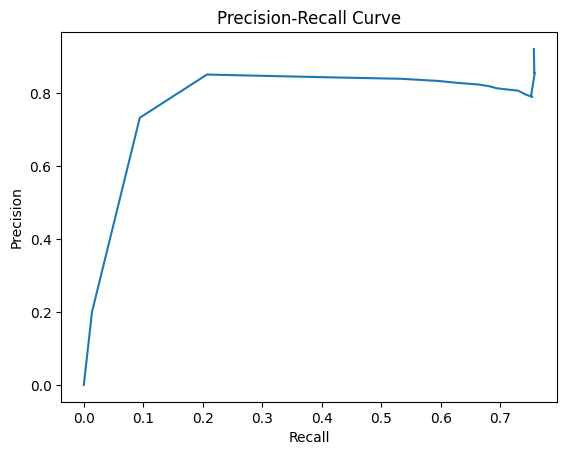

[0.9215911071043157, 0.8550007350732225, 0.8550873132715, 0.8553522133246031, 0.7924703270756612, 0.7901575585253383, 0.7964700176142413, 0.8071237697015267, 0.8113393513121657, 0.813638442382975, 0.8195365169110971, 0.8242352153219399, 0.8281885713666169, 0.8338676546781231, 0.8397283166123869, 0.8435394964747125, 0.8513252960195317, 0.7327956989247312, 0.2, 0.0]
[0.7561846067598521, 0.756983917698698, 0.756983917698698, 0.7576775894348116, 0.7514829567921365, 0.7536223252098463, 0.7426970478405213, 0.7298364801628789, 0.7058378993611165, 0.6940343169981429, 0.6805697793690577, 0.6620840382711244, 0.629573993082262, 0.5947555968805751, 0.5321932399745546, 0.41619704810212993, 0.20689330401410144, 0.09404428109386923, 0.013711054204011952, 0.0]


In [ ]:
model = YOLO(r"/content/drive/My Drive/cct20/cct20/my_yolo_project/train22/weights/best.pt")

conf_values = np.linspace(0,1,20)
precisions = []
recalls = []

for conf in conf_values:
    # Run validation with specified confidence threshold and IoU
    metrics = model.val(split="test", conf=conf, iou=0.3)

    results = metrics.box.mean_results()
    precision = results[0]
    recall = results[1]

    precisions.append(precision)
    recalls.append(recall)

plt.plot(recalls, precisions)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

print(precisions)
print(recalls)


### Drawing BBoxes

In [ ]:
model = YOLO(r"/content/drive/My Drive/cct20/cct20/my_yolo_project/train22/weights/best.pt")

test_images = [f for f in os.listdir(test_image_dir) if os.path.isfile(os.path.join(test_image_dir, f))]

if not test_images:
    raise FileNotFoundError("No images found in the test directory.")

random_image_filename = random.choice(test_images)
random_image_path = os.path.join(test_image_dir, random_image_filename)

try:
    img = Image.open(random_image_path)
except FileNotFoundError:
    raise FileNotFoundError(f"Image not found: {random_image_path}")

# Get Ground Truth Bounding Boxes
label_file = os.path.join(test_label_dir,
                          os.path.splitext(random_image_filename)[0] + ".txt")

ground_truth_boxes = []
try:
    with open(label_file, "r") as f:
        for line in f:
            parts = line.strip().split()
            class_id, x_center, y_center, width, height = map(float, parts)
            # Convert from normalized YOLO format to pixel coordinates
            img_width, img_height = img.size
            x_min = int((x_center - width / 2) * img_width)
            y_min = int((y_center - height / 2) * img_height)
            w = int(width * img_width)
            h = int(height * img_height)
            ground_truth_boxes.append((x_min, y_min, w, h))
except FileNotFoundError:
    print(f"WARNING: No label file found for {random_image_filename}.  Only showing predictions.")
    ground_truth_boxes = []


# Get Predicted Bounding Boxes
results = model.predict(source=random_image_path, conf=0.3)  # Run inference
predicted_boxes = []

if results:
    for result in results:
        for *xyxy, conf, cls in result.boxes.data:  # Iterate over each bounding box
            x1, y1, x2, y2 = map(int, xyxy)
            predicted_boxes.append((x1, y1, x2 - x1, y2 - y1, conf.item()))  # Store as (x_min, y_min, width, height, confidence)
else:
    print("No detections for this image.")


fig, ax = plt.subplots(1)
ax.imshow(img)

# Draw ground truth boxes (green)
for x_min, y_min, w, h in ground_truth_boxes:
    rect = patches.Rectangle((x_min, y_min), w, h, linewidth=2, edgecolor='g', facecolor='none', label='Ground Truth')
    ax.add_patch(rect)

# Draw predicted boxes (red)
for x_min, y_min, w, h, conf in predicted_boxes:
    rect = patches.Rectangle((x_min, y_min), w, h, linewidth=2, edgecolor='r', facecolor='none', label=f'Prediction ({conf:.2f})')
    ax.add_patch(rect)

# Adds label to distinguish ground truth and predictions
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='upper right')

plt.title(f"Predictions vs. Ground Truth for {random_image_filename}")
plt.show()